# Querying Hierarchical Data Using the `reach` Action in the `NETWORK` Actionset

In this demonstration, we load a sample company's organization structure into our CAS server, and query it to identify all employees in a single manager's reporting structure.

This example emulates the same query, but conducted using recursive SQL queries, as shown in [Recursive Query with PROC SQL](https://kansascode.blogspot.com/2021/06/recursive-query-with-proc-sql.html?m=1) as well as [Learn PostgreSQL Recursive Query By Example](https://www.postgresqltutorial.com/postgresql-recursive-query/).

We show how through use of the `reach` action, we identify all employees who report to a manager named __Megan Berry__. Traversal algorithms allow us to avoid recursion, making our code simpler to understand and debug.

----------------

The basic flow of this notebook is as follows:
1. Load the organizational structure into a Pandas DataFrame as a set of links.
2. Connect to a CAS server and upload our DataFrame.
3. Execute the `reach` action and fetch the results.
4. Compare results with the known results from the examples referenced above.

----------------
__Prepared by:__
Damian Herrick (<i class="fa fa-github" aria-hidden="true"></i>: [dtherrick](www.github.com/dtherrick))

## Imports

The modules below are needed for this exercise.

| Module             | Description                                                                        |
|:-------------------|:----------------------------------------------------------------------------------:|
| `os`               | Allows access to environment variables.                                            |
| `swat`             | SAS Python module that orchestrates communication with a CAS server.               |
| `pandas`           | Data management module we use for preparation of local data.                       |
| `graphviz.Digraph` | Used to display the organizational structure with the results of our reach query.  | 

In [1]:
import os

import swat
import pandas as pd

from graphviz import Digraph

## Sample Data

We take our sample data from the original post about recursive SQL.

| `employee_id` |     `full_name`     | `manager_id` |
|:-------------:|:-------------------:|:------------:|
|       1       | 'Michael North'     |     NULL     |
|       2       | 'Megan Berry'       |       1      |
|       3       | 'Sarah Berry'       |       1      |
|       4       | 'Zoe Black'         |       1      |
|       5       | 'Tim James'         |       1      |
|       6       | 'Bella Tucker'      |       2      |
|       7       | 'Ryan Metcalfe'     |       2      |
|       8       | 'Max Mills'         |       2      |
|       9       | 'Benjamin Glover'   |       2      |
|      10       | 'Carolyn Henderson' |       3      |
|      11       | 'Nicola Kelly'      |       3      |
|      12       | 'Alexandra Climo'   |       3      |
|      13       | 'Dominic King'      |       3      |
|      14       | 'Leonard Gray'      |       4      |
|      15       | 'Eric Rampling'     |       4      |
|      16       | 'Piers Paige'       |       7      |
|      17       | 'Ryan Henderson'    |       7      |
|      18       | 'Frank Tucker'      |       8      |
|      19       | 'Nathan Ferguson'   |       8      |
|      20       | 'Kevin Rampling'    |       8      |

For our purposes, let's put that data into a master dataframe, which we can use both in our reach calculations as well as for verifications and visualization later in this exercise.

In [2]:
# We use a list of tuples, along with a list of column names, to create the master dataframe.
colNames = ["employee_id", "full_name", "manager_id"]
data = [
    (1, "Michael North", 0),
    (2, "Megan Berry", 1),
    (3, "Sarah Berry", 1),
    (4, "Zoe Black", 1),
    (5, "Tim James", 1),
    (6, "Bella Tucker", 2),
    (7, "Ryan Metcalfe", 2),
    (8, "Max Mills", 2),
    (9, "Benjamin Glover", 2),
    (10, "Carolyn Henderson", 3),
    (11, "Nicola Kelly", 3),
    (12, "Alexandra Climo", 3),
    (13, "Dominic King", 3),
    (14, "Leonard Gray", 4),
    (15, "Eric Rampling", 4),
    (16, "Piers Paige", 7),
    (17, "Ryan Henderson", 7),
    (18, "Frank Tucker", 8),
    (19, "Nathan Ferguson", 8),
    (20, "Kevin Rampling", 8), 
]
# create the dataframe from the above source data.
dfMasterData = pd.DataFrame(data, columns=colNames)

# display the table, but we don't care about the index for this exercise.
dfMasterData.style.hide_index()

employee_id,full_name,manager_id
1,Michael North,0
2,Megan Berry,1
3,Sarah Berry,1
4,Zoe Black,1
5,Tim James,1
6,Bella Tucker,2
7,Ryan Metcalfe,2
8,Max Mills,2
9,Benjamin Glover,2
10,Carolyn Henderson,3


## Connect to our Viya (CAS) server

We now need to connect to our CAS server. Contact your SAS administrator for the proper credentials to connect to CAS using `python-swat`.

As a convention, I keep my CAS host and port set as environment variables. This allows me to both avoid placing user-specific data in notebooks, as well as adds a layer of security.

For ease-of-reading, I assign those environment variables into `host` and `port` variables, then pass them into the connection statement.

Once connected, we need access to the `PROC NETWORK` actions. In CAS terminology, that is an `actionset` so we load that now.

In [3]:
host = os.environ['CAS_HOST_ORGRD']
port = int(os.environ['CAS_PORT'])

# Connect to the server
conn = swat.CAS(host, port)

# Load the actionsets we need
conn.loadactionset('network')

NOTE: Added action set 'network'.


[actionset]

 'network'

+ Elapsed: 0.0343s, user: 0.115s, sys: 0.036s, mem: 6.26mb

## Load source tables into CAS

All of the `network` actions require a graph table. In this exercise, we simply need to pass the action a `LinkSetIn` table that represents the relationships between the employees, and a `NodeSubsetIn` table that represents the specific nodes whose reach we wish to calculate. 

As we defined in the master data above, we only need to pass the `employee_id` and `manager_id` values from each row to create the links table. Since __Michael North__ does not have a manager, we want to skip his record in the links table we upload to CAS. The easiest way is to create an intermediate dataframe using the pandas `loc` method to exclude the first row, and limit to only the `employee_id` and `manager_id` columns.

For the `NodeSubsetIn` table, we create an intermediate dataframe with a specific format. Its source must be a list of dicts, where each dictionary has two keys: `node` and `reach`. `node`'s value is the identifier of the node whose reach we calculate. `reach` is the order of reach calculations we want to calculate. Since we are only calculating for one source node, `reach`'s value is 1.

Once the intermediate dataframes are created, we upload them to CAS using the `upload` method. The `casout=` argument allows us to define the names of the CAS tables.

In [4]:
dfLinkSetIn = dfMasterData.loc[dfMasterData.employee_id>1, ['employee_id', 'manager_id']]
dfNodeSubsetIn = pd.DataFrame([{'node': 2, 'reach': 1}])

swat.options.cas.print_messages=False

_ = conn.upload(dfLinkSetIn, casout=dict(name='LinkSetIn', replace=True))
_ = conn.upload(dfNodeSubsetIn, casout=dict(name='NodeSubsetIn', replace=True))

## Find all employees who report to Megan Berry

We can find all of Megan's subordinates using the `reach` action.

The reach action takes several options:
* `links`: The name of the source table that contains the full set of links that describe our graph.
* `nodessubset`: The name of the source table that contains the nodes and reach we wish to search against.
* `direction`: Define whether the graph in the `links` option is a directed or undirected graph. For this exercise, we must explicitly state that this is a directed graph using the string `directed`.
* `linksvar`: We include this option because we did not name our columns `from` and `to`. (If we had, we could ignore this option). For our calculation, we pass a dictionary where `manager_id` is the `from` value, and `employee_id` is the `to` value.
* `maxreach`: an integer value that defines how many levels deep we should calculate the reach. We use 2 in this case.
* `outReachNodes`: an output table with the nodes that are included in the reach calculations.
* `outReachLinks`: an output table with the link pairs that are included in the reach calculations.
* `outCounts`: an output summary table that has the total count of nodes included in the reach calculations.

In [5]:
%%time
conn.network.reach(
    direction     = "directed",
    links         = {"name":"LinkSetIn"},
    linksvar      = {"from": "manager_id", "to": "employee_id"},
    nodessubset   = {"name":"NodeSubSetIn"},
    outReachNodes = {"name":"ReachNodes",  "replace":True},
    outReachLinks = {"name":"ReachLinks",  "replace":True},
    outCounts     = {"name":"ReachCounts", "replace":True},
    maxreach      = 2)

CPU times: user 45.5 ms, sys: 2.16 ms, total: 47.7 ms
Wall time: 169 ms


[OutputCasTables]

                 casLib         Name Label  Rows  Columns                                           casTable
 0  CASUSERHDFS(daherr)   ReachLinks           9        3  CASTable('ReachLinks', caslib='CASUSERHDFS(dah...
 1  CASUSERHDFS(daherr)   ReachNodes          10        2  CASTable('ReachNodes', caslib='CASUSERHDFS(dah...
 2  CASUSERHDFS(daherr)  ReachCounts           1        4  CASTable('ReachCounts', caslib='CASUSERHDFS(da...

[ProblemSummary]

 Problem Summary
 
             Name1           Label1       cValue1  nValue1
 0        numNodes  Number of Nodes            20     20.0
 1        numLinks  Number of Links            19     19.0
 2  graphDirection  Graph Direction      Directed      NaN

[SolutionSummary]

 Solution Summary
 
          Name1           Label1       cValue1  nValue1
 0  problemType     Problem Type         Reach      NaN
 1       status  Solution Status            OK      NaN
 2      cpuTime         CPU Time          0.00  0.00000
 3     realTime        Real Time          0.00  0.00165

[solutionStatus]

 'OK'

[solutionStatusCode]

 0

+ Elapsed: 0.0902s, user: 0.114s, sys: 0.165s, mem: 315mb

## Review the output tables

If the reach action was successful, it will output some summary and log information in the notebook. We asked it to generate three tables, so let's just fetch those tables and verify that the data looks OK.

For the `ReachLinks` table, a quick pass at the first four rows shows Megan has four direct reports. If we glance back at the master data above, we see that, yes, her employee id is 2, and the `ReachLinks` table shows four employees with a manager id of 2.

For `ReachCounts`, we see that node 2 connects to 10 nodes. This is good, since there are 20 total nodes - we know Megan doesn't manage everyone.

For `ReachNodes`, we simply verify that there are 10 rows (nodes) included.

Based on the quick verification, all three tables look good.

In [6]:
conn.fetch('ReachLinks')

,reach,manager_id,employee_id
0,1.0,2.0,6.0
1,1.0,2.0,7.0
2,1.0,2.0,8.0
3,1.0,2.0,9.0
4,1.0,7.0,16.0
5,1.0,7.0,17.0
6,1.0,8.0,18.0
7,1.0,8.0,19.0
8,1.0,8.0,20.0


In [7]:
conn.fetch('ReachNodes')

,reach,node
0,1.0,2.0
1,1.0,6.0
2,1.0,7.0
3,1.0,8.0
4,1.0,9.0
5,1.0,16.0
6,1.0,17.0
7,1.0,18.0
8,1.0,19.0
9,1.0,20.0


In [8]:
conn.fetch('ReachCounts')

,reach,node,count,count_not
0,1.0,2.0,10.0,10.0


## Verify that our call to the reach action matches the output of recursive SQL

From the initial PostgreSQL recursive SQL article, we expect these results:

 employee_id  | manager_id   |    full_name
-------------:|:------------:|:-----------------
           2  |          1   | Megan Berry
           6  |          2   | Bella Tucker
           7  |          2   | Ryan Metcalfe
           8  |          2   | Max Mills
           9  |          2   | Benjamin Glover
          16  |          7   | Piers Paige
          17  |          7   | Ryan Henderson
          18  |          8   | Frank Tucker
          19  |          8   | Nathan Ferguson
          20  |          8   | Kevin Rampling
          
Let's use the `ReachNodes` table and the `dfMasterData` dataframe to try to reproduce this table.

Our approach:
1. Create a list of only the node id's in the `ReachNodes` returned by the reach action. A simple list comprehension accomplishes this, in the `report_list` variable.
2. Then, use that list with the master data to generate a boolean pandas series, where values are True if they are in Megan's reporting reach, False if not.
3. Filter the master dataframe to create a `Reports` table we can use to compare.
4. Display that final reports table.

We see that, yes, the reach action provides the same results as the recursive SQL statement.

In [9]:
report_list = [int(i) for i in  conn.fetch('ReachNodes')['Fetch']['node'].to_list()]

reports_series = dfMasterData.employee_id.isin(report_list)
dfReports = dfMasterData[reports_series]

dfReports.style.hide_index()

employee_id,full_name,manager_id
2,Megan Berry,1
6,Bella Tucker,2
7,Ryan Metcalfe,2
8,Max Mills,2
9,Benjamin Glover,2
16,Piers Paige,7
17,Ryan Henderson,7
18,Frank Tucker,8
19,Nathan Ferguson,8
20,Kevin Rampling,8


## Bonus: Verify Results Visually

Finally, let's produce a tree diagram of our organizational structure, and highlight the employees in Megan's reporting structure. This approach allows us to quickly verify whether the reach action produced the correct reporting structure.

We use `graphviz` since it provides an easy means to programmatically create a directed network graph diagram. Since we can't directly translate pandas dataframes to graphviz dot syntax, we need to convert our dataframes to Python lists.

Our approach is as follows:
1. Create a `graph` object from the master dataframe. Calling the `to_dict` method with `orient='records'` set returns a list of dictionaries, one for each row in the dataframe.
2. Create two lists of tuples - one for the reporting list, and one for everyone else. We simply use list comprehensions filtered by the `report_list` we created above to generate these variables.
3. Define our graphviz object as a `Digraph`.
4. Add the nodes in the reporting structure. For our purposes, we highlight by filling these nodes with light blue.
5. Add all remaining nodes. Leave them unfilled.
6. Use the full graph - which already has the link relationships - to add the links to our visualization.
7. Since this is a wide image, we create a `final_plot` object in which we pass our dot language and use the `unflatten` option with a `stagger` value of 4.
8. Finally, display the plot.

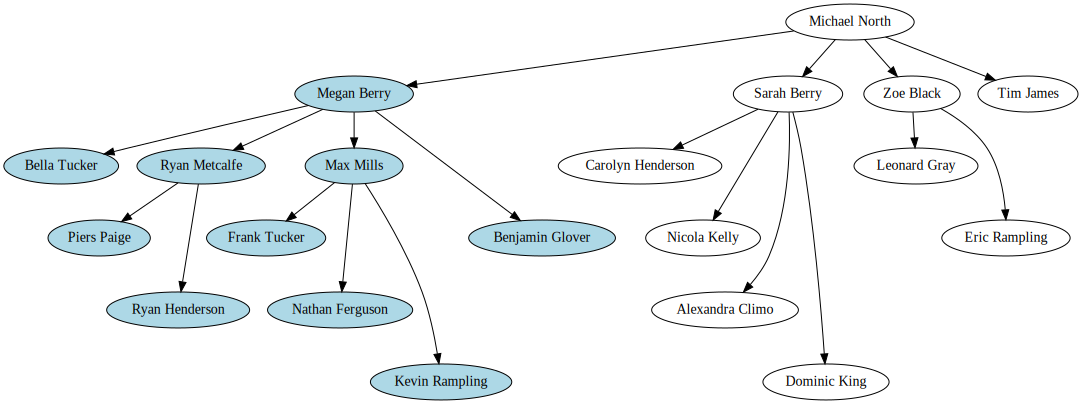

In [10]:
graph = dfMasterData.to_dict(orient='records')

report_nodes = [(node['employee_id'], node['full_name']) for node in graph if node['employee_id'] in report_list]
other_nodes = [(node['employee_id'], node['full_name']) for node in graph if node['employee_id'] not in report_list]

dot = Digraph()

for item in report_nodes:
    dot.node(str(item[0]), item[1], style='filled', fillcolor='lightblue')

for item in other_nodes:
    dot.node(str(item[0]), item[1])

# note that we skip the first row in "graph" because that is the head of the tree with no manager. We don't need a phantom link called "0"
for pair in graph[1:]:
    dot.edge(str(pair['manager_id']), str(pair['employee_id']))

final_plot = dot.unflatten(stagger=4)

final_plot

## Clean up everything. 

Make sure we know what tables we created, drop them, and close our connection.
(This is probably overkill, since everything in this session is ephemeral anyway, but good practice nonetheless.

In [11]:
table_list = conn.tableinfo()["TableInfo"]["Name"].to_list()

for table in table_list:
    conn.droptable(name=table, quiet=True)

conn.close()

## Conclusion

In this notebook, we used the `reach` action in the `network` actionset for SAS Viya to determine all employees in a single person's reporting structure. We checked our results against the same calculations performed by recursive SQL statements in both PostgreSQL and SAS `PROC SQL`. 

Both a results table and a network diagram demonstrate that the reach action results are equivalent to the recursive SQL statements. Using the reach action is both less verbose, and requires less debugging and design than developing custom recursive queries.